In [1]:
import os
import sys
import argparse

MAIN_PATH = os.path.abspath(os.path.join('../src'))
sys.path.append(MAIN_PATH)

import numpy as np
import pandas as pd
import torch
from prophet import Prophet

import proloaf.datahandler as dh
import proloaf.modelhandler as mh
import proloaf.baselinehandler as baselines
from proloaf.tensorloader import TimeSeriesData
import proloaf.plot as plot

from proloaf.confighandler import read_config
from proloaf.cli import parse_with_loss
from proloaf import metrics
from proloaf.event_logging import create_event_logger

logger = create_event_logger('baselines')

2022-03-28 22:17:56 - event_logging - WARNING - Logger name "proloaf.baselinehandler" could not be found in the logging config. Default logger was created


In [2]:
# Configs for the prediction job, model name and data path
config_path = 'opsd'
PAR = read_config(config_path, main_path="../")
model_name = PAR["model_name"]
data_path = PAR["data_path"]

INFILE = os.path.join("../", data_path)  # input factsheet
INMODEL = os.path.join("../", PAR["output_path"], model_name)
OUTDIR = os.path.join("../", PAR["evaluation_path"])

# Generate the directory to store the results
if not os.path.exists(OUTDIR):
    os.makedirs(OUTDIR)

# Configs for the datetime settings of the timeseries
SCALE_DATA = True
LIMIT_HISTORY = 365
SLIDING_WINDOW = 1
DAY_FIRST = True
SEASONALITY=24
PERIODICITY=7
RESOLUTION = 'H'

# Configs for the ARIMA models (default, and will be changed upon tuning)
ORDER = (3, 1, 0)
sORDER = (2, 0, 0, 24)
arima_order = ORDER
sarima_order = sORDER

ALPHA = 1.96

# Use of exogeneous variables
EXOG = True

# Loading existing models (and data to device)
APPLY_EXISTING_MODEL = False
DEVICE = "cpu"

# RNN related settings
torch.set_printoptions(linewidth=120) # Display option for output
torch.set_grad_enabled(True)

# Here is the list of settings, fetched from the configurations in the config path for this station. 
# Each prediction job might necessitate a different setting in the config:
PAR

{'data_path': './data/opsd.csv',
 'output_path': './oracles/',
 'exploration_path': './targets/opsd/tuning.json',
 'evaluation_path': './oracles/eval_opsd_recurrent/',
 'log_path': './logs/',
 'model_name': 'opsd_recurrent',
 'target_id': ['DE_load_actual_entsoe_transparency'],
 'target_list': None,
 'start_date': None,
 'history_horizon': 147,
 'forecast_horizon': 24,
 'cap_limit': 1,
 'train_split': 0.6,
 'validation_split': 0.8,
 'periodicity': 24,
 'optimizer_name': 'adam',
 'exploration': False,
 'cuda_id': None,
 'feature_groups': [{'name': 'main',
   'scaler': ['minmax', 0.0, 1.0],
   'features': ['DE_load_actual_entsoe_transparency',
    'DE_temperature',
    'DE_radiation_direct_horizontal',
    'DE_radiation_diffuse_horizontal']},
  {'name': 'aux',
   'scaler': None,
   'features': ['hour_0',
    'hour_1',
    'hour_2',
    'hour_3',
    'hour_4',
    'hour_5',
    'hour_6',
    'hour_7',
    'hour_8',
    'hour_9',
    'hour_10',
    'hour_11',
    'hour_12',
    'hour_13',


### Read load data and set frequency and timestamps
We set the frequency of timesteps to hours. This frequency of the dataframe is e.g. used in the naive seasonal decomposition forecast model.

We take all features into consideration that have been categorized as either encoder or decoder feature. We will then only take those different from the endogeneous feature. So here we need to remove the target (=endogenous) feature.

In [3]:
df = pd.read_csv(INFILE, sep=';',index_col=0)
df = dh.fill_if_missing(df, periodicity=SEASONALITY)
df = dh.set_to_hours(df, freq=RESOLUTION)
df = df.asfreq(freq='H')

target = PAR['target_id']
enc_features = PAR['encoder_features']
dec_features = PAR['decoder_features']

#now just make sure that the exogenous features do not include the target itself as endog already does.
if target in enc_features: enc_features.remove(target)
if target in dec_features: dec_features.remove(target)

2022-03-28 22:17:56 - datahandler - INFO - No missing data


### Now the data shall be scaled and split according to the scalers and train-test split defined in the config

In [4]:
if SCALE_DATA:
    scaler = dh.MultiScaler(PAR["feature_groups"])
    df = scaler.fit_transform(df)

df_train, df_val = dh.split(df, splits=[PAR["validation_split"]])

Lets checkout which endog and exog features we are dealing with:

In [5]:
display(df_train)

AT_load_actual_entsoe_transparency  \
Time                                                      
2014-12-31 23:00:00                              5946.0   
2015-01-01 00:00:00                              5946.0   
2015-01-01 01:00:00                              5726.0   
2015-01-01 02:00:00                              5347.0   
2015-01-01 03:00:00                              5249.0   
...                                                 ...   
2018-12-31 14:00:00                              7345.0   
2018-12-31 15:00:00                              7576.0   
2018-12-31 16:00:00                              7828.0   
2018-12-31 17:00:00                              7729.0   
2018-12-31 18:00:00                              7241.0   

                     DE_load_actual_entsoe_transparency  AT_temperature  \
Time                                                                      
2014-12-31 23:00:00                            0.212880          -6.495   
2015-01-01 00:00:00                            0.212880          -6.503   
2015-01-01 01:00:00                            0.190909          -6.458   
2015-01-01 02:00:00                            0.168656          -6.253   
2015-01-01 03:00:00                            0.161282          -5.908   
...                                                 ...             ...   
2018-12-31 14:00:00                            0.434994           0.893   
2018-12-31 15:00:00                            0.475261          -0.434   
2018-12-31 16:00:00                            0.530297          -0.805   
2018-12-31 17:00:00                            0.522945          -0.888   
2018-12-31 18:00:00                            0.481186          -1.022   

                     AT_radiation_direct_horizontal  \
Time                                                  
2014-12-31 23:00:00                          0.0000   
2015-01-01 00:00:00                          0.0000   
2015-01-01 01:00:00                          0.0000   
2015-01-01 02:00:00                          0.0000   
2015-01-01 03:00:00                          0.0000   
...                                             ...   
2018-12-31 14:00:00                          3.8872   
2018-12-31 15:00:00                          0.0182   
2018-12-31 16:00:00                          0.0000   
2018-12-31 17:00:00                          0.0000   
2018-12-31 18:00:00                          0.0000   

                     AT_radiation_diffuse_horizontal  DE_temperature  \
Time                                                                   
2014-12-31 23:00:00                           0.0000        0.243870   
2015-01-01 00:00:00                           0.0000        0.243019   
2015-01-01 01:00:00                           0.0000        0.241898   
2015-01-01 02:00:00                           0.0000        0.240361   
2015-01-01 03:00:00                           0.0000        0.239178   
...                                              ...             ...   
2018-12-31 14:00:00                          35.1772        0.373570   
2018-12-31 15:00:00                           0.5869        0.361777   
2018-12-31 16:00:00                           0.0000        0.362338   
2018-12-31 17:00:00                           0.0000        0.363646   
2018-12-31 18:00:00                           0.0000        0.364871   

                     DE_radiation_direct_horizontal  \
Time                                                  
2014-12-31 23:00:00                        0.000000   
2015-01-01 00:00:00                        0.000000   
2015-01-01 01:00:00                        0.000000   
2015-01-01 02:00:00                        0.000000   
2015-01-01 03:00:00                        0.000000   
...                                             ...   
2018-12-31 14:00:00                        0.000571   
2018-12-31 15:00:00                        0.000017   
2018-12-31 16:00:00                        0.000000   
2018-12-31 17:00:00

Here, in the later methods we currently do not use torch tensors. But we apply a similar tranform just as it is done, with with the ProLoaF Tensorloader, resulting in pandas dataframes for the input and output values on the train and validation set. Some of the baseline methods, only work with **numpy arrays** instead of dataframes. We create the datastructures for both purposes here:

In [6]:
dataset_train = TimeSeriesData(
    df_train,
    history_horizon=PAR["history_horizon"],
    forecast_horizon=PAR["forecast_horizon"],
    encoder_features=PAR["target_id"],
    decoder_features=None,
    target_id=PAR["target_id"],
)
dl_train = dataset_train.make_data_loader(batch_size=1, shuffle=False)
x_train_1D = np.array([input.squeeze().numpy() for input, _, _ in dl_train])
y_train_1D = np.array([target.squeeze().numpy() for _, _, target in dl_train])

2022-03-28 22:17:56 - tensorloader - DEBUG - frame not prepared


We seperately generate the dataloaders and numpy arrays for the validation data

In [7]:
dataset_val = TimeSeriesData(
    df_val,
    history_horizon=PAR["history_horizon"],
    forecast_horizon=PAR["forecast_horizon"],
    encoder_features=PAR["target_id"],
    decoder_features=None,
    target_id=PAR["target_id"],
)
dl_val = dataset_val.make_data_loader(batch_size=1, shuffle=False)
x_val_1D = np.array([input.squeeze().numpy() for input, _, _ in dl_val])
y_val_1D = np.array([target.squeeze().numpy() for _, _, target in dl_val])

2022-03-28 22:17:58 - tensorloader - DEBUG - frame not prepared


### Exogenous variables

In [8]:
# We will generate exogenous variables already now for some of the baseline methods that make use of them.
df_exog_train = df_train[enc_features+dec_features]
df_exog_val = df_val[enc_features+dec_features]

### Training and Prediction

We set the number of predictions NUM_PRED to 365 with each 24 hours but make sure that the maximum number of predictions is set to no larger than the validation data length.

In [9]:
NUM_PRED=min(365*24,len(y_val_1D-1-PAR['forecast_horizon']))

We want to fill step by step empty arrays with the expected values and prediction intervals (quantiles), computed from each of the following baseline models. The array baseline_method will contain the names of the computed methods, which will serve as labels lateron in the benchmark step.

In [10]:
mean_forecast = []
upper_PI = []
lower_PI = []
baseline_method = []

### <u>Baseline model 1</u>:   Naive Persistence model

In [11]:
naive_expected_values, naive_y_pred_upper, naive_y_pred_lower = baselines.persist_forecast(
    x_train_1D, x_val_1D, y_train_1D, PAR['forecast_horizon'], alpha=ALPHA)
mean_forecast.append(naive_expected_values)
upper_PI.append(naive_y_pred_upper)
lower_PI.append(naive_y_pred_lower)
baseline_method.append('simple-naive')

Train a naive (persistence) timeseries model...
Training and validating naive (persistence) model completed.


### <u>Baseline model 2</u>: Seasonal Naive

* <u>**Major difference from the persistence model**</u>: Instead of forecasting last observed value for the entire horizon, it considers the <u>**previous day's value for each corresponding hour in the forecast horizon.**</u>
* Lets call it the periodic model. That is the default solution. By changing seasonality and periodicity the timeseries pattern that is underlying the data can be respected.

In [12]:
# SNaïve
s_naive_expected_values, s_naive_y_pred_upper, s_naive_y_pred_lower = baselines.seasonal_forecast(
    x_train_1D, x_val_1D, y_train_1D, PAR['forecast_horizon'], periodicity=1,
    seasonality=SEASONALITY, alpha=ALPHA)
mean_forecast.append(s_naive_expected_values)
upper_PI.append(s_naive_y_pred_upper)
lower_PI.append(s_naive_y_pred_lower)
baseline_method.append('seasonal-naive')

Train a seasonal naive timeseries model with seasonality= 24 ...
Training and validating seasonal naive model completed.


### <u>Baseline model 3</u>: Seasonally Decomposed Naive

In [13]:
# Decomposition(+ any#model)
sd_naive_expected_values, sd_naive_y_pred_upper, sd_naive_y_pred_lower = baselines.persist_forecast(
    x_train_1D, x_val_1D, y_train_1D, PAR['forecast_horizon'],
    periodicity=PERIODICITY, seasonality=SEASONALITY,decomposed=True, alpha=ALPHA)
mean_forecast.append(sd_naive_expected_values)
upper_PI.append(sd_naive_y_pred_upper)
lower_PI.append(sd_naive_y_pred_lower)
baseline_method.append('naive-stl')

Train a naive timeseries model cleared with seasonal decomposition (STL)...
Training and validating naive (STL) completed.


### <u>Baseline model 4</u>: ARIMA

In [14]:
#baselines.test_stationarity(df_train[target],maxlag=PERIODICITY*SEASONALITY)
###############################ARIMA####################################
arima_model=None
if(APPLY_EXISTING_MODEL): arima_model = baselines.load_baseline(OUTDIR,name='ARIMA')
if arima_model == None:
    arima_model,_,_,arima_order,_ = baselines.auto_sarimax_wrapper(
        endog=df_train[target],
        order=ORDER,
        seasonal_order=None,
        seasonal = False,
        lag=PERIODICITY*SEASONALITY,
        train_limit=LIMIT_HISTORY, 
        grid_search=True
    )
else:  logger.info("Loaded existing fitted ARIMA model from {!s}".format(OUTDIR))
baselines.save_baseline(OUTDIR, arima_model, name='ARIMA',  save_predictions=False)

Train a (S)ARIMA(X) timeseries model...
Training set too long for ARIMA model. ARIMA does not improve with very long training sets. Set training set to:  365
Training SARIMA(X) with parameter grid search by auto-arima...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1548.213, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1146.630, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1490.787, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1428.740, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1146.630, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1556.279, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1557.737, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-1556.268, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1554.197, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-1557.737, Time=0.03 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.8

### <u>Baseline model 5</u>: SARIMA

In [15]:
##############################SARIMA####################################
sarima_model=None
if(APPLY_EXISTING_MODEL): sarima_model = baselines.load_baseline(OUTDIR,name='SARIMA')
if sarima_model == None:
    sarima_model,_,_,sarima_order,sarima_sorder = baselines.auto_sarimax_wrapper(
        endog=df_train[target],
        order=ORDER,
        seasonal_order=sORDER,
        seasonal = True,
        lag=PERIODICITY*SEASONALITY,
        m=SEASONALITY,
        train_limit=LIMIT_HISTORY,
        grid_search = True
    )
else: logger.info("Loaded existing fitted SARIMA model from {!s}".format(OUTDIR))
baselines.save_baseline(OUTDIR, sarima_model, name='SARIMA', save_predictions=False)

Train a (S)ARIMA(X) timeseries model...
Training set too long for ARIMA model. ARIMA does not improve with very long training sets. Set training set to:  365
Training SARIMA(X) with parameter grid search by auto-arima...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=-1732.842, Time=4.87 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=-1146.630, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=inf, Time=4.82 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=-1648.546, Time=5.16 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=-1146.630, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[24] intercept   : AIC=-1548.213, Time=0.12 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=-1963.806, Time=10.49 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=-1948.754, Time=11.50 sec
 ARIMA(1,1,1)(2,0,1)[24] intercept   : AIC=-1963.044, Time=85.54 sec
 ARIMA(1,1,1)(1,0,2)[24] intercept   : AIC=-1962.983, Time=60.36 sec
 ARIMA(1,1,1)(0,0,2)[24] intercept   : AIC=-1822.306, Time

### <u>Baseline model 6</u>: ARIMAX

In [16]:
###############################ARIMAX####################################
arimax_model = None
if(APPLY_EXISTING_MODEL): arimax_model = baselines.load_baseline(OUTDIR, name='ARIMAX')
if arimax_model == None:
    arimax_model,_,_,_,_ = baselines.auto_sarimax_wrapper(
        endog=df_train[target],
        exog=df_exog_train,
        order=arima_order,
        seasonal_order=None,
        seasonal=False,
        train_limit=LIMIT_HISTORY,
        lag=PERIODICITY*SEASONALITY,
        grid_search=True
    )
else: logger.info("Loaded existing fitted ARIMAX model from {!s}".format(OUTDIR))
baselines.save_baseline(OUTDIR, arimax_model, name='ARIMAX', save_predictions=False)

Train a (S)ARIMA(X) timeseries model...
Training set too long for ARIMA model. ARIMA does not improve with very long training sets. Set training set to:  365
Training SARIMA(X) with parameter grid search by auto-arima...
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-7625.597, Time=0.76 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-7631.610, Time=0.58 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-7627.762, Time=0.63 sec


/home/jupyter/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1897: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-7629.610, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 2.704 seconds


/home/jupyter/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:2937: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
/home/jupyter/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:2937: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


Train ARIMAX with order: (0, 0, 0)
Saving fitted sarimax model


### <u>Baseline model 7</u>: SARIMAX

In [17]:
###############################SARIMAX###################################
sarimax_model = None
if (APPLY_EXISTING_MODEL): sarimax_model = baselines.load_baseline(OUTDIR, name='SARIMAX')
if sarimax_model == None:
    sarimax_model, _, _, _, _ = baselines.auto_sarimax_wrapper(
        endog=df_train[target],
        exog=df_exog_train,
        order=sarima_order,
        seasonal_order=sarima_sorder,
        seasonal=True,
        train_limit=LIMIT_HISTORY,
        lag=PERIODICITY * SEASONALITY,
        m=SEASONALITY,
        grid_search=True
    )
else: logger.info("Loaded existing fitted SARIMAX model from {!s}".format(OUTDIR))
baselines.save_baseline(OUTDIR, sarimax_model, name='SARIMAX', save_predictions=False)

Train a (S)ARIMA(X) timeseries model...
Training set too long for ARIMA model. ARIMA does not improve with very long training sets. Set training set to:  365
Training SARIMA(X) with parameter grid search by auto-arima...
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-7631.610, Time=0.58 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,0,0)(0,0,0)[24]          
Total fit 

/home/jupyter/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:2937: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
/home/jupyter/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:2937: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


Train SARIMAX with order: (0, 0, 0)  and seasonal order: (0, 0, 0, 24)
Saving fitted sarimax model


#### Only fetch predictions of that ARMA Model, that has the lowest AIC, since making forecasts on the whole validation set causes a high memory comsuming effort

In [18]:
list_of_models = [arima_model, sarima_model, arimax_model, sarimax_model]
arima_models = pd.DataFrame(data=[arima_model.aic, sarima_model.aic, arimax_model.aic, sarimax_model.aic], index=["ARIMA","SARIMA","ARIMAX","SARIMAX"], columns = {"AIC"})
print(arima_models)

min_index = arima_models.index.get_indexer(arima_models[arima_models["AIC"] == arima_models["AIC"].min()].index)[0]
print(arima_models[arima_models["AIC"] == arima_models["AIC"].min()])
best_arima_model = list_of_models[min_index]

                 AIC
ARIMA   -1557.737148
SARIMA  -1970.768283
ARIMAX    579.126034
SARIMAX   579.126034
                AIC
SARIMA -1970.768283


We see that the SARIMA model has the best information criterion, so we fetch its results, but  
we let the ARIMA models re-fit over the validation set. That is why we fetch NUM_Pred from the dataframe now.

In [19]:
SARIMA_expected_values, SARIMA_y_pred_upper, SARIMA_y_pred_lower = \
    baselines.make_forecasts(
        endog_train=df_train[target],
        endog_val=df_val[target],
        fitted=sarima_model,
        forecast_horizon=PAR["forecast_horizon"],
        train_limit=LIMIT_HISTORY,
        limit_steps=NUM_PRED,
        pi_alpha=ALPHA,
        online=True,
)

mean_forecast.append(SARIMA_expected_values)
upper_PI.append(SARIMA_y_pred_upper)
lower_PI.append(SARIMA_y_pred_lower)
baseline_method.append("SARIMA")

logger.info("Best Arima Model is the trained:  {!s}".format(baseline_method[-1:][0]))

Added re-training set too long for SARIMAX model. SARIMAX does not improve with very long training sets. Set re-training set to latest:  365  entries
Predictions made without exogenous variables
Training and validating (S)ARIMA(X) completed.
2022-03-28 23:10:35 - <ipython-input-19-2867ca2b6f39> - INFO - Best Arima Model is the trained:  SARIMA


### <u>Benchmark model 8</u>:   Facebook Prophet

We need to make slight changes in the data that we have read in to adapt it to Prophet's required datastructure.

The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.
            
See: [prophet/notebooks/quick_start.ipynb](https://github.com/facebook/prophet/blob/main/notebooks/quick_start.ipynb)

In [20]:
df_train_prophet = pd.DataFrame(df_train[target].values, columns=['y'])
df_train_prophet['ds']=df_train.index
df_train_prophet = df_train_prophet[['ds','y']]
df_train_prophet

ds         y
0     2014-12-31 23:00:00  0.212880
1     2015-01-01 00:00:00  0.212880
2     2015-01-01 01:00:00  0.190909
3     2015-01-01 02:00:00  0.168656
4     2015-01-01 03:00:00  0.161282
...                   ...       ...
35055 2018-12-31 14:00:00  0.434994
35056 2018-12-31 15:00:00  0.475261
35057 2018-12-31 16:00:00  0.530297
35058 2018-12-31 17:00:00  0.522945
35059 2018-12-31 18:00:00  0.481186

[35060 rows x 2 columns]

In [21]:
m = Prophet()
m.fit(df_train_prophet)

future = m.make_future_dataframe(periods=NUM_PRED+PAR["forecast_horizon"], freq=RESOLUTION)
forecast = m.predict(future)

In [22]:
prophet_prediction = pd.DataFrame(forecast.iloc[-NUM_PRED-PAR["forecast_horizon"]:])

expected_values = np.lib.stride_tricks.sliding_window_view(
    prophet_prediction['yhat'].to_numpy(), 
    PAR["forecast_horizon"]
)
upper_PI_values = np.lib.stride_tricks.sliding_window_view(
    prophet_prediction['yhat_upper'].to_numpy(), 
    PAR["forecast_horizon"]
)
lower_PI_values = np.lib.stride_tricks.sliding_window_view(
    prophet_prediction['yhat_lower'].to_numpy(), 
    PAR["forecast_horizon"]
)

mean_forecast.append(expected_values[:NUM_PRED])
upper_PI.append(upper_PI_values[:NUM_PRED])
lower_PI.append(lower_PI_values[:NUM_PRED])
baseline_method.append('facebook-prophet')

### Now we move to the evaluation step to compare the fitted models on new data
We determine a set of metrics that we are interested in. We will look into different metrics, in parts the total averages ```analyzed_metrics_avg```, the performance per sample averaged over the forecast timesteps ```analyzed_metrics_sample```, and vice-versa the performance per future timestep averaged over the all samples (N=NUM_PRED).

In [23]:
analyzed_metrics_avg = [
    metrics.Mse(),
    metrics.Rmse(),
    metrics.Sharpness(),
    metrics.Picp(),
    metrics.Rae(),
    metrics.Mae(),
    metrics.Mis(),
    metrics.Mase(),
    metrics.PinnballLoss(),
    metrics.Residuals(),
]

In [24]:
analyzed_metrics_sample = [
    metrics.Mse(),
    metrics.Rmse(),
    metrics.Sharpness(),
    metrics.Picp(),
    metrics.Rae(),
    metrics.Mis(),
    metrics.PinnballLoss(),
    metrics.Residuals(),
]

In [25]:
analyzed_metrics_ts = [
    metrics.Rmse(),
    metrics.Sharpness(),
    metrics.Picp(),
    metrics.Mis(),
]

In [26]:
baseline_method

['simple-naive', 'seasonal-naive', 'naive-stl', 'SARIMA', 'facebook-prophet']

Lets create some empty variables to fill in the following loop over mean foreacasts

In [27]:
results = pd.DataFrame(index=[metric.id for metric in analyzed_metrics_avg])
results_per_sample = {} 
results_per_timestep = {}
true_values = torch.zeros([len(mean_forecast), NUM_PRED, PAR["forecast_horizon"]])
forecasts = torch.zeros([len(mean_forecast), NUM_PRED, PAR["forecast_horizon"]])
upper_limits = torch.zeros([len(mean_forecast), NUM_PRED, PAR["forecast_horizon"]])
lower_limits = torch.zeros([len(mean_forecast), NUM_PRED, PAR["forecast_horizon"]])

We need to differentiate the length of the input data to each model depending on the chosen baseline method. This is done in the following:

baseline_method[i] = 'simple-naive'


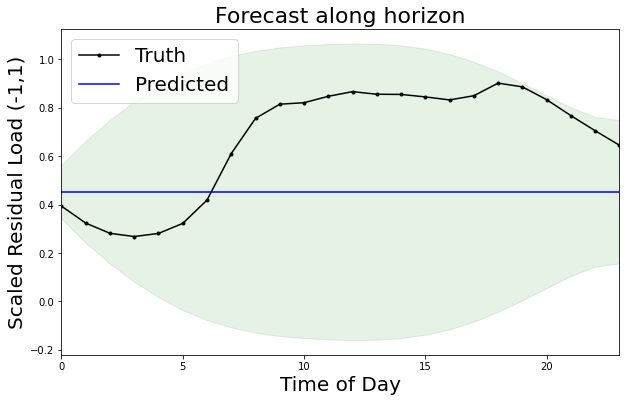

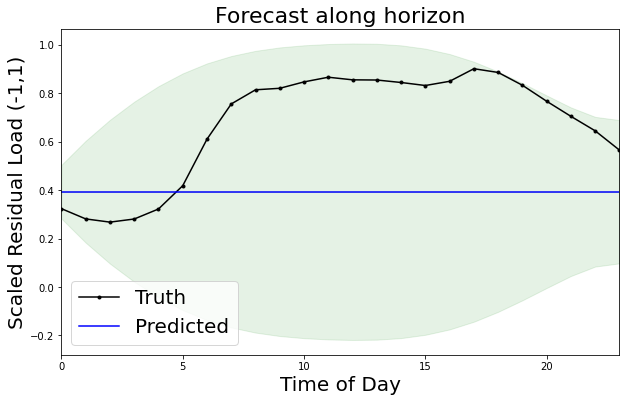

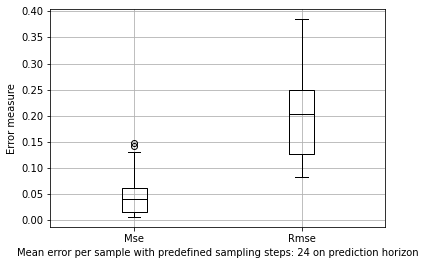

baseline_method[i] = 'seasonal-naive'


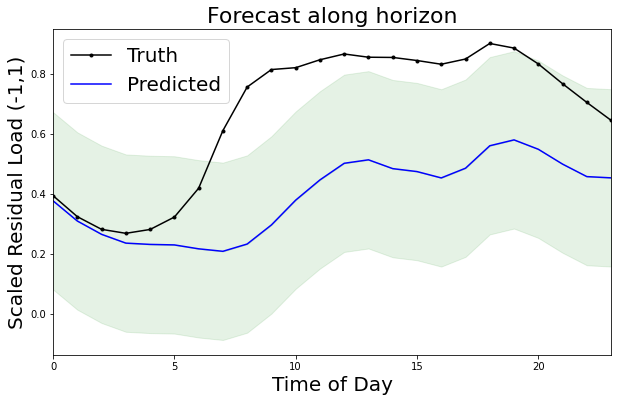

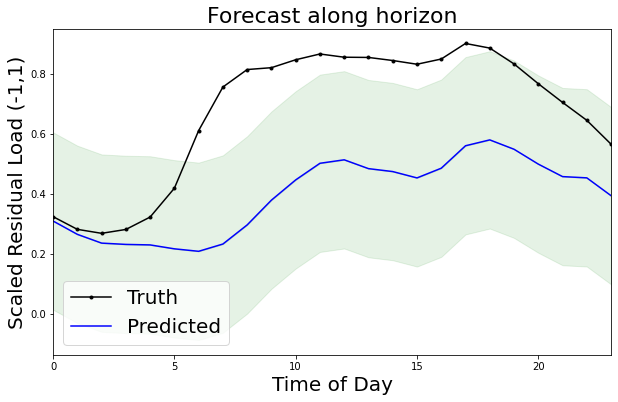

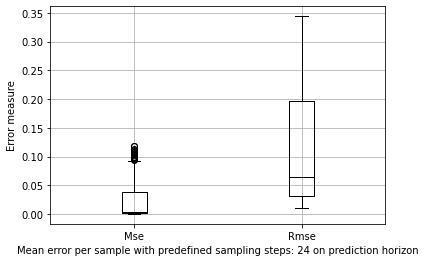

baseline_method[i] = 'naive-stl'


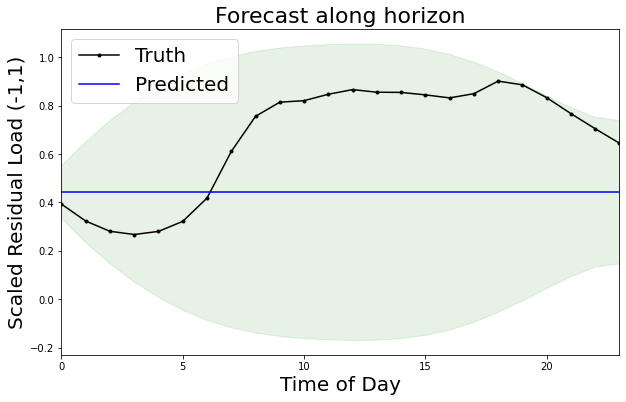

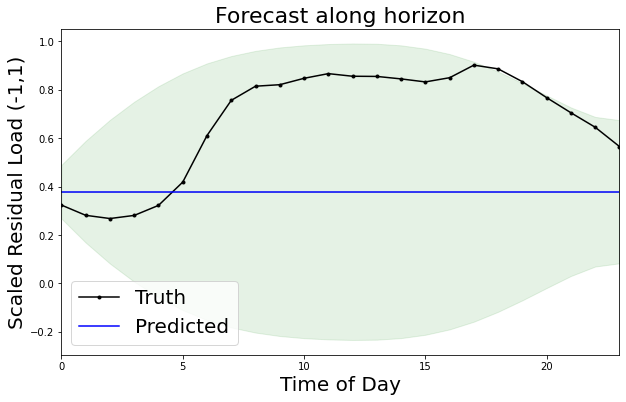

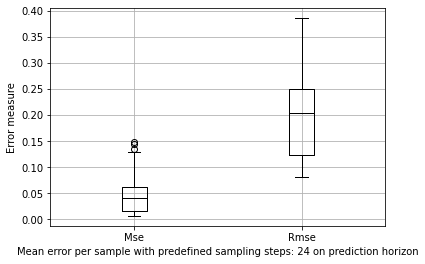

baseline_method[i] = 'SARIMA'


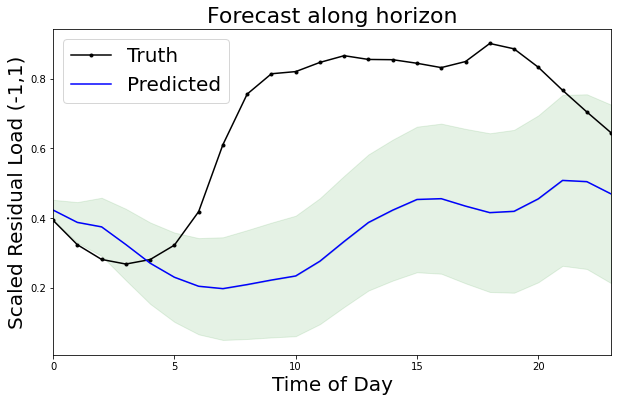

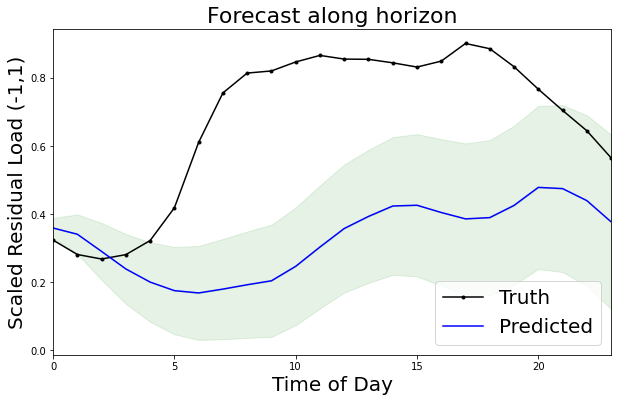

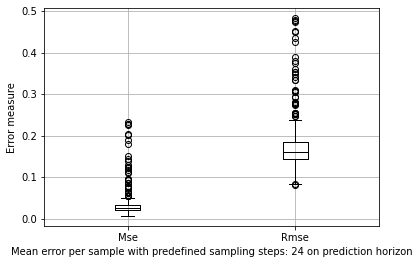

baseline_method[i] = 'facebook-prophet'


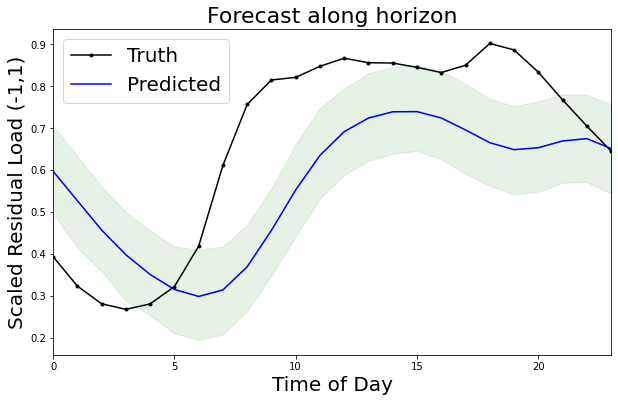

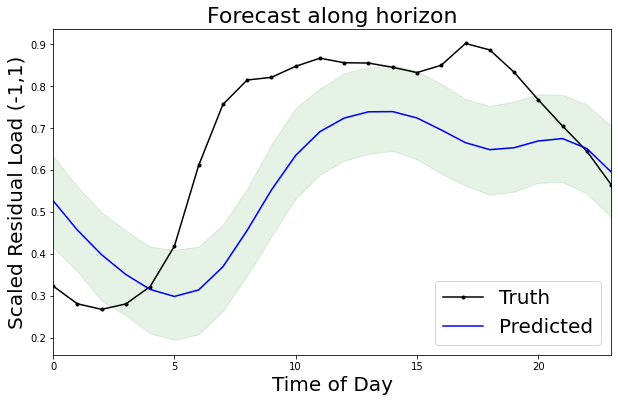

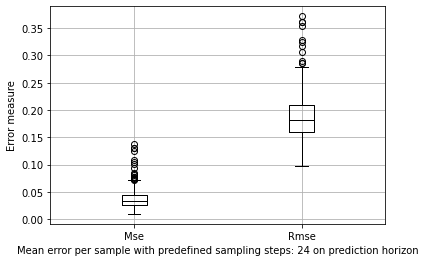

In [28]:
#==========================Evaluate ALL==========================
for i, mean in enumerate(mean_forecast):
    if mean is None:
        # skip if no mean prediciton
        continue
    print(f"{baseline_method[i] = }")
    (
        results[baseline_method[i]],
        results_per_timestep[baseline_method[i]],
        results_per_sample[i],
        true_values[i],
        forecasts[i],
        upper_limits[i],
        lower_limits[i],
    ) = baselines.eval_forecast(
        config=PAR,
        forecasts=mean[:NUM_PRED],
        endog_val=y_val_1D[:NUM_PRED, :],
        upper_limits=upper_PI[i][:NUM_PRED],
        lower_limits=lower_PI[i][:NUM_PRED],
        path=OUTDIR,
        model_name="test" + baseline_method[i],
        analyzed_metrics_avg=analyzed_metrics_avg,
        analyzed_metrics_sample=analyzed_metrics_sample,
        analyzed_metrics_timesteps=analyzed_metrics_ts,
    )

One issue with the above code is that the results per timestep per baseline, are as many values as predictions steps we have, evaluated for multiple metrics and multiple baseline methods. We now merge all the information into a multi-index, multi-column pandas dataframe for the plotting fuctions lateron

### Print Results Table

In [29]:
results_per_timestep_per_baseline = pd.concat(
    results_per_timestep.values(), keys=results_per_timestep.keys(), axis=1
)
results_per_sample = pd.concat(
    results_per_sample.values(), keys=results_per_timestep.keys(), axis=1
)
results_per_timestep_per_baseline.head()

simple-naive                                seasonal-naive            \
          Rmse Sharpness       Picp       Mis           Rmse Sharpness   
0     0.054756  0.222362  95.031998  0.297340       0.150275  0.591735   
1     0.103538  0.420806  94.659683  0.542200       0.150275  0.591738   
2     0.146116  0.594036  93.996513  0.722356       0.150275  0.591739   
3     0.182829  0.743820  94.845840  0.833291       0.150275  0.591739   
4     0.214115  0.871795  96.777199  0.917361       0.150275  0.591734   

                      naive-stl                                   SARIMA  \
       Picp       Mis      Rmse Sharpness       Picp       Mis      Rmse   
0  90.71553  0.888948  0.054691  0.222078  95.125076  0.296523  0.211131   
1  90.71553  0.888946  0.103399  0.420276  94.589874  0.541620  0.211747   
2  90.71553  0.888945  0.146019  0.593709  93.996513  0.721350  0.211703   
3  90.71553  0.888944  0.182748  0.743549  94.834206  0.832809  0.211003   
4  90.71553  0.888949  0.214044  0.871535  96.719025  0.915828  0.209794   

                                 facebook-prophet                       \
  Sharpness       Picp       Mis             Rmse Sharpness       Picp   
0  0.058736  12.658523  5.612721         0.194941  0.220219  43.397324   
1  0.116486  25.421757  4.756390         0.194937  0.220224  43.397324   
2  0.167142  34.589878  4.088094         0.194930  0.220229  43.397324   
3  0.205210  40.523560  3.614725         0.194923  0.220234  43.408958   
4  0.233782  44.874928  3.265429         0.194919  0.220238  43.420593   

             
        Mis  
0  3.119191  
1  3.118930  
2  3.118550  
3  3.118195  
4  3.118104

### Plot the results

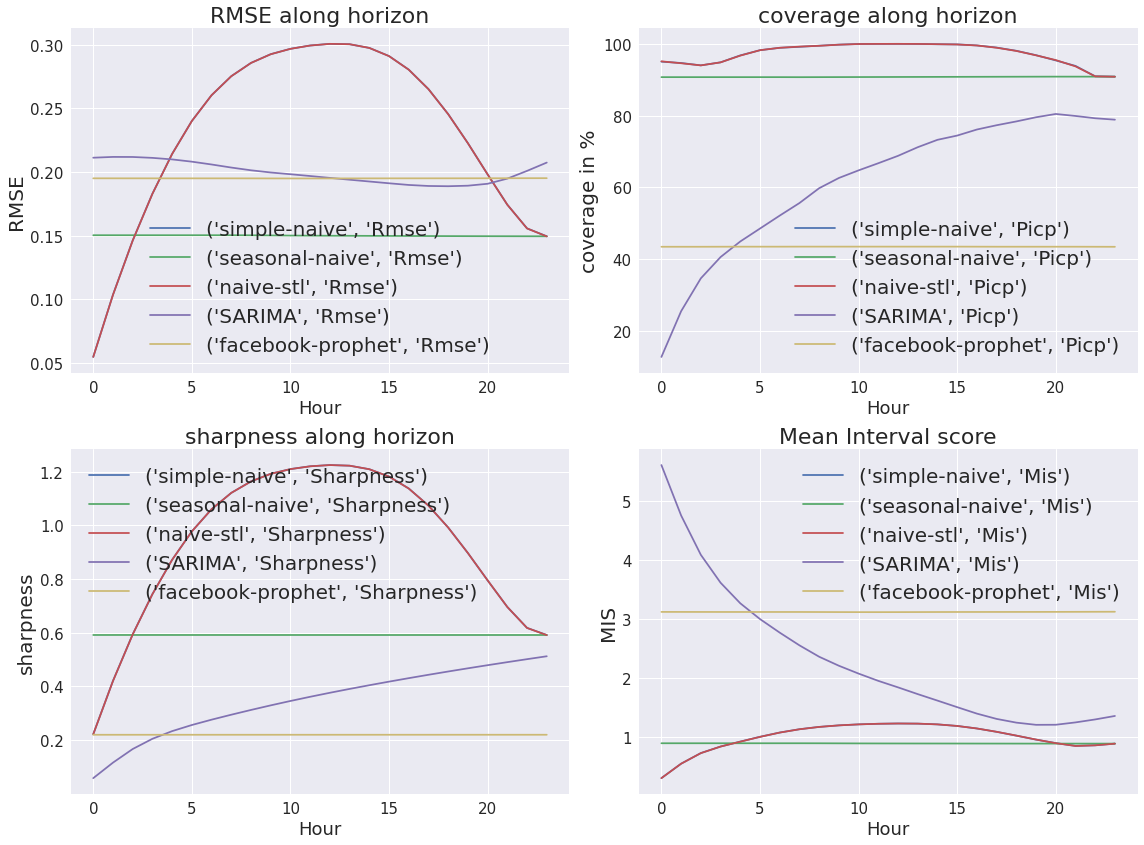

In [30]:
# plot metrics
# rmse_horizon, sharpness_horizon, coverage_horizon, mis_horizon, OUTPATH, title
plot.plot_metrics(
    results_per_timestep_per_baseline.xs(
        "Rmse", axis=1, level=1, drop_level=False
    ),
    results_per_timestep_per_baseline.xs(
        "Sharpness", axis=1, level=1, drop_level=False
    ),
    results_per_timestep_per_baseline.xs(
        "Picp", axis=1, level=1, drop_level=False
    ),
    results_per_timestep_per_baseline.xs(
        "Mis", axis=1, level=1, drop_level=False
    ),
    OUTDIR + "baselines",
)

We see that the best performing methods are on average, the Sarimax, Naive-STL, and seasonal naive. So we only go ahead and explore those ones in the next steps.

### Plot a historgramm of residuals

element = 'simple-naive'
element = 'seasonal-naive'
element = 'naive-stl'
element = 'SARIMA'
element = 'facebook-prophet'


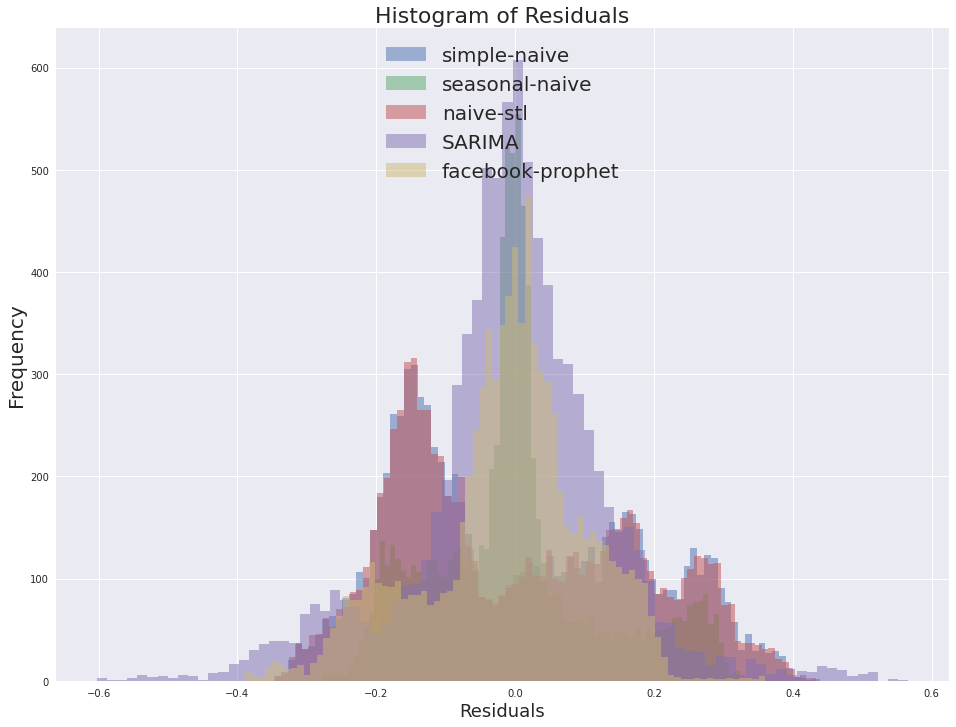

In [31]:
plot.plot_hist(
    data=results_per_sample.xs("Residuals", axis=1, level=1, drop_level=True),
    save_to=OUTDIR + "baselines",
    bins=80,
)

## Now let us fetch forecasts from an RNN trained model
The steps to prepare the data, train the model and generate predictions are all exlained in the example notebook on day-ahead prediction with ProLoaF applied on the open power system data.
There the results are pickled, which we will load here:

In [32]:
rnn_dataset_val = TimeSeriesData(
    df_val,
    history_horizon=PAR["history_horizon"],
    forecast_horizon=PAR["forecast_horizon"],
    encoder_features=PAR["encoder_features"],
    decoder_features=PAR["decoder_features"],
    target_id=PAR["target_id"],
)

In [33]:
with torch.no_grad():
    ## LOAD RNN MODEL
    rnn_model = mh.ModelHandler.load_model(f"{INMODEL}.pkl", locate='cpu')
    rnn_model.to(DEVICE)
    
    dataloader = rnn_dataset_val.make_data_loader(batch_size=None, shuffle=False)
    logger.info(f"benchmarking {rnn_model.name}")
    inputs_enc, inputs_dec, targets = next(iter(dataloader))
    quantiles = rnn_model.loss_metric.get_quantile_prediction(
        predictions=rnn_model.predict(inputs_enc, inputs_dec),
        target=targets,
    )
    results_per_sample_RNN = mh.ModelHandler.benchmark(
    rnn_dataset_val,
    [rnn_model],
    test_metrics=analyzed_metrics_sample,
    avg_over="time",
)

2022-03-28 23:11:00 - tensorloader - DEBUG - frame not prepared
2022-03-28 23:11:00 - <ipython-input-33-c23c1a26d1c9> - INFO - benchmarking opsd_recurrent
2022-03-28 23:11:02 - tensorloader - DEBUG - tensor already prepared
2022-03-28 23:11:02 - modelhandler - INFO - benchmarking opsd_recurrent


In [34]:
RNN_targets = targets
RNN_forecasts = quantiles.get_mean().unsqueeze(dim=2)
RNN_upper_limits = quantiles.select_upper_bound().values
RNN_lower_limits = quantiles.select_lower_bound().values

In [35]:
#transpose to same dimensions:
baseline_targets_transposed = true_values.transpose(1,2)[:,:,:len(RNN_forecasts)-PAR['forecast_horizon']]
baseline_forecasts_transposed = forecasts.transpose(1,2)[:,:,:len(RNN_forecasts)-PAR['forecast_horizon']]
baseline_upper_limits_transposed = upper_limits.transpose(1,2)[:,:,:len(RNN_forecasts)-PAR['forecast_horizon']]
baseline_lower_limits_transposed = lower_limits.transpose(1,2)[:,:,:len(RNN_forecasts)-PAR['forecast_horizon']]

all_true_values = torch.cat((baseline_targets_transposed, RNN_targets[PAR['forecast_horizon']:].transpose(0,2)),0).transpose(1,2)
all_forecasts = torch.cat((baseline_forecasts_transposed, RNN_forecasts[PAR['forecast_horizon']:].transpose(0,2)),0).transpose(1,2)
all_upper_limits = torch.cat((baseline_upper_limits_transposed, RNN_upper_limits[PAR['forecast_horizon']:].transpose(0,2)),0).transpose(1,2)
all_lower_limits = torch.cat((baseline_lower_limits_transposed, RNN_lower_limits[PAR['forecast_horizon']:].transpose(0,2)),0).transpose(1,2)

In [36]:
all_methods = baseline_method
all_methods.append('RNN')

In [37]:
all_results_per_sample = results_per_sample.join(results_per_sample_RNN[:NUM_PRED])

element = 'simple-naive'
element = 'seasonal-naive'
element = 'naive-stl'
element = 'SARIMA'
element = 'facebook-prophet'
element = 'opsd_recurrent'


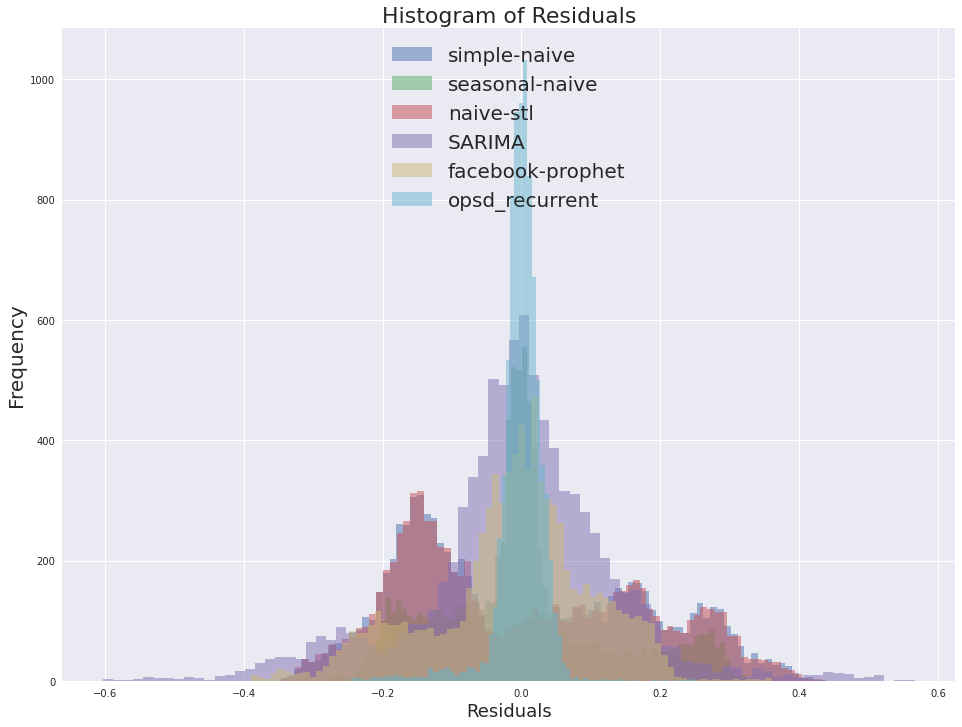

In [38]:
with torch.no_grad():    
    plot.plot_hist(
        data=all_results_per_sample.xs("Residuals", axis=1, level=1, drop_level=True),
        save_to=OUTDIR + "baselines",
        bins=80,
    )

## Compare RNN with Prophet forecasts with plot over test-horizon

In [39]:
opsd_recurrent=np.array([RNN_targets[int(i/PAR['forecast_horizon'])*PAR['forecast_horizon']].squeeze().numpy() for i in range(NUM_PRED)])

In [40]:
opsd_recurrent=opsd_recurrent[::PAR['forecast_horizon']].reshape(-1,1).T[0]

In [41]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.line(df_val[target].iloc[:NUM_PRED])
fig.add_trace(go.Scatter(x=df_val[target].iloc[:NUM_PRED].index, y=prophet_prediction['yhat'],
                         mode="lines",line=dict(color='#EF553B'), name="prophet-prediction"))
fig.add_trace(go.Scatter(x=df_val[target].iloc[:NUM_PRED].index, y=opsd_recurrent[PAR['forecast_horizon']:NUM_PRED+PAR['forecast_horizon']],
                         mode="lines", name="rnn-prediction"))

fig.show()